# Brain Tumor Segmentation using Pytorch

######   Note: References listed at the end

In [ ]:
!pip install -qqq segmentation-models-pytorch
!pip install -qqq torchmetrics

# Libraries

In [3]:
# importing required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import gc
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp


%matplotlib inline
from IPython.display import Image, display
from skimage import io

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import normalize

from PIL import Image

import torchvision
from torchvision import transforms

# Data Laoding and Preparation

In [4]:
data_path = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [5]:
# Extracts every other file path into filenames and masks lists.
filenames = data_path[::2]
masks = data_path[1::2]

In [6]:
# Limiting to 1500 images
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print("initial data size frame", df.shape) 
df=df[:1500]
df

initial data size frame (7858, 2)


,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
1495,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1496,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1497,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1498,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
org_image = df[~df['img_path'].str.contains("mask")] # Original Brain images
mask_image = df[df['img_path'].str.contains("mask")] # Corresponding Mask images

In [8]:
#check
org_image, mask_image
print(len(org_image))

750


In [9]:
# Sort file paths by numerical value and confirm image/mask matches.
img_s = sorted(org_image["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_image["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check confirms image/mask matches.
idx = random.randint(0, len(img_s)-1)
print("Image path:", img_s[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_46.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_46_mask.tif


In [10]:
print(len(img_s))
print(len(masks))
datadisp=pd.DataFrame({"imgs":img_s,"mask":masks})
pd.set_option('display.max_colwidth',None)
datadisp

750
750


,imgs,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif
...,...,...
745,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69_mask.tif
746,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif
747,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71_mask.tif
748,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72_mask.tif


In [11]:
#Creating DataFrame with sorted file paths of images and masks.

brain_mri_df = pd.DataFrame({"patient_id": org_image.patient_id.values,"img_path": img_s,
                           'mask_path':masks})
# Display DataFrame with full contents
pd.set_option('display.max_colwidth',None)
brain_mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif
...,...,...,...
745,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69_mask.tif
746,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif
747,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71_mask.tif
748,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72_mask.tif


In [12]:
# function to check whether an image contains a tumor.
def tumor_check(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1   #tumor present
    else:
        return 0  #tumor absent

In [13]:
#checking for tumors
brain_mri_df['mask'] = brain_mri_df['mask_path'].apply(lambda x: tumor_check(x))

brain_mri_df['mask_path'] = brain_mri_df['mask_path'].apply(lambda x: str(x))
pd.set_option('display.max_colwidth',None)
print(brain_mri_df.shape)
brain_mri_df

(750, 4)


,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif,0
...,...,...,...,...
745,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_69_mask.tif,0
746,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_70_mask.tif,0
747,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_71_mask.tif,0
748,TCGA_DU_5854_19951104,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_72_mask.tif,0


In [14]:
# Dropping "patient id"
brain_mri_df.drop(columns=['patient_id'],inplace=True)

In [15]:
# preparing loaders
img_trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

])

msk_trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

In [16]:
# Normalizing pixels

def pix_brightness(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    
    return (img, mask)

In [17]:
#initializing Dataset

class prepareDs(Dataset):
    def __init__(self, df= brain_mri_df, 
                 pix_brightness = pix_brightness, 
                 img_trans=img_trans, msk_trans=msk_trans):
        self.df = df
        self.img_trans = img_trans
        self.msk_trans = msk_trans
        self.pix_brightness= pix_brightness

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        image, mask = self.pix_brightness(image, mask)

        if self.img_trans:
            image = self.img_trans(image).float()

        if self.msk_trans:
            mask = self.msk_trans(mask)
        return image, mask

In [18]:
# PyTorch Dataloaders for training validation and testing
def Data_loaders(df= brain_mri_df,
                    train_num= int(brain_mri_df.shape[0] * .6), 
                    valid_num= int(brain_mri_df.shape[0] * .8), 
                    bs = 32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)    
    test  = df[valid_num:].reset_index(drop=True)

    train_ds = prepareDs(df = train)
    valid_ds = prepareDs(df = valid)
    test_ds = prepareDs(df = test)

    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, shuffle = True)
    
    print("setup complete")
    
    return train_loader, valid_loader, test_loader,len(train_ds),len(test_ds)

In [19]:
train_loader, valid_loader, test_loader,train_len,test_len = Data_loaders(df= brain_mri_df,
                                                            train_num= int(brain_mri_df.shape[0] * .65), 
                                                            valid_num= int(brain_mri_df.shape[0] * .85), 
                                                            bs = 32)

setup complete


In [20]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

In [21]:
# cuda check
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

# Model Setup

In [22]:
# Block module
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):        
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))        
        return self.pool(x), x   

In [23]:
# defining U-net architecture 
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        #Encoders
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)

        #Decoders
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)       
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)

    def forward(self, x):
        x, e1 = self.en1(x)     
        x, e2 = self.en2(x)
        x, e3 = self.en3(x) 
        x, e4 = self.en4(x)
        _, x = self.en5(x)

        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        _,  x = self.de4(x)
        
        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        _, x = self.de3(x)
        
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        _, x = self.de2(x)
        
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        _, x = self.de1(x)
        
        x = self.conv_last(x)              
        return x
        


        

In [24]:
unet = UNet().to(device)
unet

UNet(
  (en1): Block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(256, eps=1e-05, momentum

In [25]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss,MSELoss,BCELoss,CrossEntropyLoss
# loss_fn = BCEWithLogitsLoss()
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(unet.parameters(), )

In [26]:
# training one epoch
def train_one_epoch(model = unet, 
                    dataloader = train_loader, 
                    loss_fn = loss_fn, 
                    optimizer = optimizer, 
                    epoch = 1):
    model.train() 
    train_loss, dataset_size = 0,  0
    
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for data in bar:
        x = data[0].cuda()  
        y_true = data[1].cuda()
        y_pred = model(x)          
        
        loss = loss_fn(y_pred, y_true)
        
        pred_mask = (y_pred > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        bs = x.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        
        


        bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    
    metrics['loss'] = train_epoch_loss

    return metrics

In [27]:
# Validating one epoch
@torch.no_grad()
def valid_one_epoch(model = unet, 
                    dataloader = valid_loader, 
                    loss_fn = loss_fn,
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].cuda()    
            y_true = data[1].cuda() 
            y_pred = model(x)        
            
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

           
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    
    metrics['loss'] = valid_epoch_loss

    return metrics

# Setting up for Training

In [28]:
# Training set up
import copy

def run_training(model = unet, 
                 loss_fn = loss_fn, 
                 train_loader = train_loader,
                 valid_loader = valid_loader,
                 optimizer = optimizer, 
                 n_epochs=100, 
                 early_stop = 20,
                 scheduler = None):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    lowest_epoch, lowest_loss = np.inf, np.inf
    
    train_history, valid_history = [],  []
    train_recalls, valid_recalls = [],  []
    
    train_pres, valid_pres = [],  []
    train_accs, valid_accs = [],  []
    
    train_f1s, valid_f1s = [],  []
    
    train_per_ious, valid_per_ious = [], []
    train_dataset_ious, valid_dataset_ious = [], []
    
    print_iter = 5

    best_score = 0
    best_model = "None"

    for epoch in range(0, n_epochs):
        gc.collect()

        train_metrics = train_one_epoch(model= model,
                                       dataloader = train_loader,
                                       optimizer = optimizer,
                                       epoch = epoch + 1
                                       )
        
        valid_metrics = valid_one_epoch(model,
                                       dataloader = valid_loader,
                                       epoch = epoch + 1)
        
        
        train_history += [train_metrics['loss']]
        valid_history += [valid_metrics['loss']]
        
        train_recalls += [train_metrics['recall']]
        valid_recalls += [valid_metrics['recall']]
        
        train_pres += [train_metrics['precision']]
        valid_pres += [valid_metrics['precision']]
        
        train_accs += [train_metrics['accuracy']]
        valid_accs += [valid_metrics['accuracy']]
        
        train_f1s += [train_metrics['f1_score']]
        valid_f1s += [valid_metrics['f1_score']]

        
        print()
        if (epoch + 1) % print_iter == 0:
            print(f"Epoch:{epoch + 1}|TL:{train_metrics['loss']:.3e}|VL:{valid_metrics['loss']:.3e}|F1:{valid_metrics['f1_score']:.4f}")
            print()
            
        if best_score < valid_metrics['f1_score']:
            print("!111")
            print(f"Validation F1 Improved({best_score:.2f}) --> ({ valid_metrics['f1_score']:.2f})")
            best_model = model
            best_score = valid_metrics['f1_score']
            best_model = copy.deepcopy(model.state_dict())
            PATH2 =  f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved")
            print()

        if valid_metrics['loss']< lowest_loss:
            print("!222")
            print(f"Validation Loss Improved({lowest_loss:.4e}) --> ({ valid_metrics['loss']:.4e})")
            lowest_loss = valid_metrics['loss']
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"model.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")
            print()
       
                
    print()
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))

    
    model.load_state_dict(torch.load('./model_f1.bin'))

    result = dict()
    result["Train Loss"] = train_history
    result["Valid Loss"] = valid_history
    
    result["Train Recall"] = train_recalls
    result["Valid Recall"] = valid_recalls
    
    result["Train Precision"] = train_pres
    result["Valid Precision"] = valid_pres
    
    result["Train Accuracy"] = train_accs
    result["Valid Accuracy"] = valid_accs
    
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
    
    
    return model, result

# Training the Model

In [36]:
model, result = run_training(model = unet, 
                             loss_fn = loss_fn, 
                             optimizer = optimizer, 
                             n_epochs = 100)

INFO: GPU - Tesla T4



EP:1 | TL:8.877e-01 | ACC: 0.98 | F1: 0.451 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:1 | VL:9.252e-01 | ACC: 0.91 | F1: 0.156 : 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]



!111
Validation F1 Improved(0.00) --> (0.16)
Better_F1_Model Saved

!222
Validation Loss Improved(inf) --> (9.2517e-01)
Better Loss Model Saved



EP:2 | TL:8.573e-01 | ACC: 0.98 | F1: 0.480 : 100%|██████████| 16/16 [00:27<00:00,  1.75s/it]
EP:2 | VL:8.770e-01 | ACC: 0.99 | F1: 0.566 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]



!111
Validation F1 Improved(0.16) --> (0.57)
Better_F1_Model Saved

!222
Validation Loss Improved(9.2517e-01) --> (8.7698e-01)
Better Loss Model Saved



EP:3 | TL:7.964e-01 | ACC: 0.99 | F1: 0.585 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:3 | VL:8.643e-01 | ACC: 0.98 | F1: 0.481 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]



!222
Validation Loss Improved(8.7698e-01) --> (8.6426e-01)
Better Loss Model Saved



EP:4 | TL:7.240e-01 | ACC: 0.99 | F1: 0.584 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:4 | VL:8.526e-01 | ACC: 0.95 | F1: 0.220 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



!222
Validation Loss Improved(8.6426e-01) --> (8.5256e-01)
Better Loss Model Saved



EP:5 | TL:6.105e-01 | ACC: 0.99 | F1: 0.657 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:5 | VL:7.792e-01 | ACC: 0.97 | F1: 0.331 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]



Epoch:5|TL:6.105e-01|VL:7.792e-01|F1:0.3313

!222
Validation Loss Improved(8.5256e-01) --> (7.7918e-01)
Better Loss Model Saved



EP:6 | TL:4.807e-01 | ACC: 0.99 | F1: 0.741 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:6 | VL:5.310e-01 | ACC: 0.99 | F1: 0.620 : 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]



!111
Validation F1 Improved(0.57) --> (0.62)
Better_F1_Model Saved

!222
Validation Loss Improved(7.7918e-01) --> (5.3097e-01)
Better Loss Model Saved



EP:7 | TL:4.127e-01 | ACC: 0.99 | F1: 0.719 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:7 | VL:4.202e-01 | ACC: 0.99 | F1: 0.674 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]



!111
Validation F1 Improved(0.62) --> (0.67)
Better_F1_Model Saved

!222
Validation Loss Improved(5.3097e-01) --> (4.2021e-01)
Better Loss Model Saved



EP:8 | TL:3.571e-01 | ACC: 0.99 | F1: 0.729 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:8 | VL:6.522e-01 | ACC: 0.99 | F1: 0.592 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:9 | TL:3.285e-01 | ACC: 0.99 | F1: 0.721 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:9 | VL:7.076e-01 | ACC: 0.99 | F1: 0.444 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:10 | TL:3.040e-01 | ACC: 0.99 | F1: 0.743 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:10 | VL:5.676e-01 | ACC: 0.98 | F1: 0.485 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]



Epoch:10|TL:3.040e-01|VL:5.676e-01|F1:0.4852



EP:11 | TL:2.680e-01 | ACC: 1.00 | F1: 0.766 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:11 | VL:3.766e-01 | ACC: 0.99 | F1: 0.655 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



!222
Validation Loss Improved(4.2021e-01) --> (3.7661e-01)
Better Loss Model Saved



EP:12 | TL:2.759e-01 | ACC: 1.00 | F1: 0.763 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:12 | VL:5.599e-01 | ACC: 0.98 | F1: 0.483 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:13 | TL:2.395e-01 | ACC: 1.00 | F1: 0.781 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:13 | VL:4.303e-01 | ACC: 0.99 | F1: 0.611 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:14 | TL:2.262e-01 | ACC: 1.00 | F1: 0.796 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:14 | VL:4.039e-01 | ACC: 0.99 | F1: 0.625 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:15 | TL:2.202e-01 | ACC: 1.00 | F1: 0.799 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:15 | VL:3.924e-01 | ACC: 0.99 | F1: 0.642 : 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]



Epoch:15|TL:2.202e-01|VL:3.924e-01|F1:0.6419



EP:16 | TL:2.193e-01 | ACC: 1.00 | F1: 0.804 : 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]
EP:16 | VL:4.284e-01 | ACC: 0.99 | F1: 0.623 : 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


EP:17 | TL:1.778e-01 | ACC: 1.00 | F1: 0.838 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:17 | VL:3.815e-01 | ACC: 0.99 | F1: 0.668 : 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


EP:18 | TL:2.110e-01 | ACC: 1.00 | F1: 0.827 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:18 | VL:3.514e-01 | ACC: 0.99 | F1: 0.672 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



!222
Validation Loss Improved(3.7661e-01) --> (3.5135e-01)
Better Loss Model Saved



EP:19 | TL:2.101e-01 | ACC: 1.00 | F1: 0.817 : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]
EP:19 | VL:3.436e-01 | ACC: 0.99 | F1: 0.680 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



!111
Validation F1 Improved(0.67) --> (0.68)
Better_F1_Model Saved

!222
Validation Loss Improved(3.5135e-01) --> (3.4357e-01)
Better Loss Model Saved



EP:20 | TL:1.908e-01 | ACC: 1.00 | F1: 0.822 : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]
EP:20 | VL:3.421e-01 | ACC: 0.99 | F1: 0.676 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



Epoch:20|TL:1.908e-01|VL:3.421e-01|F1:0.6762

!222
Validation Loss Improved(3.4357e-01) --> (3.4213e-01)
Better Loss Model Saved



EP:21 | TL:1.725e-01 | ACC: 1.00 | F1: 0.835 : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]
EP:21 | VL:3.952e-01 | ACC: 0.99 | F1: 0.658 : 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


EP:22 | TL:1.875e-01 | ACC: 1.00 | F1: 0.836 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:22 | VL:4.122e-01 | ACC: 0.99 | F1: 0.537 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:23 | TL:2.259e-01 | ACC: 1.00 | F1: 0.794 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:23 | VL:3.853e-01 | ACC: 0.99 | F1: 0.601 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:24 | TL:1.852e-01 | ACC: 1.00 | F1: 0.827 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:24 | VL:3.459e-01 | ACC: 0.99 | F1: 0.685 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



!111
Validation F1 Improved(0.68) --> (0.68)
Better_F1_Model Saved



EP:25 | TL:1.898e-01 | ACC: 1.00 | F1: 0.826 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:25 | VL:3.624e-01 | ACC: 0.99 | F1: 0.680 : 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]



Epoch:25|TL:1.898e-01|VL:3.624e-01|F1:0.6799



EP:26 | TL:1.673e-01 | ACC: 1.00 | F1: 0.845 : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]
EP:26 | VL:4.524e-01 | ACC: 0.99 | F1: 0.616 : 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


EP:27 | TL:2.112e-01 | ACC: 1.00 | F1: 0.798 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:27 | VL:3.904e-01 | ACC: 0.99 | F1: 0.657 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:28 | TL:2.751e-01 | ACC: 0.99 | F1: 0.758 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:28 | VL:3.574e-01 | ACC: 0.99 | F1: 0.644 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:29 | TL:1.931e-01 | ACC: 1.00 | F1: 0.814 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:29 | VL:3.755e-01 | ACC: 0.99 | F1: 0.629 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:30 | TL:1.744e-01 | ACC: 1.00 | F1: 0.832 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:30 | VL:3.478e-01 | ACC: 0.99 | F1: 0.708 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



Epoch:30|TL:1.744e-01|VL:3.478e-01|F1:0.7084

!111
Validation F1 Improved(0.68) --> (0.71)
Better_F1_Model Saved



EP:31 | TL:1.715e-01 | ACC: 1.00 | F1: 0.837 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:31 | VL:3.458e-01 | ACC: 0.99 | F1: 0.670 : 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


EP:32 | TL:1.748e-01 | ACC: 1.00 | F1: 0.842 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:32 | VL:3.698e-01 | ACC: 0.99 | F1: 0.633 : 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


EP:33 | TL:1.558e-01 | ACC: 1.00 | F1: 0.851 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:33 | VL:3.085e-01 | ACC: 1.00 | F1: 0.734 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]



!111
Validation F1 Improved(0.71) --> (0.73)
Better_F1_Model Saved

!222
Validation Loss Improved(3.4213e-01) --> (3.0850e-01)
Better Loss Model Saved



EP:34 | TL:1.488e-01 | ACC: 1.00 | F1: 0.856 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:34 | VL:3.712e-01 | ACC: 0.99 | F1: 0.689 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:35 | TL:1.543e-01 | ACC: 1.00 | F1: 0.858 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:35 | VL:3.046e-01 | ACC: 1.00 | F1: 0.747 : 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]



Epoch:35|TL:1.543e-01|VL:3.046e-01|F1:0.7473

!111
Validation F1 Improved(0.73) --> (0.75)
Better_F1_Model Saved

!222
Validation Loss Improved(3.0850e-01) --> (3.0464e-01)
Better Loss Model Saved



EP:36 | TL:1.444e-01 | ACC: 1.00 | F1: 0.870 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:36 | VL:3.136e-01 | ACC: 1.00 | F1: 0.692 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:37 | TL:1.553e-01 | ACC: 1.00 | F1: 0.850 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:37 | VL:3.866e-01 | ACC: 0.99 | F1: 0.687 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:38 | TL:1.373e-01 | ACC: 1.00 | F1: 0.868 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:38 | VL:3.031e-01 | ACC: 1.00 | F1: 0.708 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]



!222
Validation Loss Improved(3.0464e-01) --> (3.0311e-01)
Better Loss Model Saved



EP:39 | TL:1.633e-01 | ACC: 1.00 | F1: 0.851 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:39 | VL:4.270e-01 | ACC: 0.99 | F1: 0.601 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:40 | TL:1.481e-01 | ACC: 1.00 | F1: 0.862 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:40 | VL:3.235e-01 | ACC: 1.00 | F1: 0.721 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]



Epoch:40|TL:1.481e-01|VL:3.235e-01|F1:0.7207



EP:41 | TL:1.530e-01 | ACC: 1.00 | F1: 0.860 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:41 | VL:3.253e-01 | ACC: 1.00 | F1: 0.732 : 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


EP:42 | TL:1.363e-01 | ACC: 1.00 | F1: 0.873 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:42 | VL:2.891e-01 | ACC: 1.00 | F1: 0.734 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]



!222
Validation Loss Improved(3.0311e-01) --> (2.8909e-01)
Better Loss Model Saved



EP:43 | TL:1.275e-01 | ACC: 1.00 | F1: 0.867 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:43 | VL:3.266e-01 | ACC: 1.00 | F1: 0.733 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:44 | TL:1.252e-01 | ACC: 1.00 | F1: 0.880 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:44 | VL:3.197e-01 | ACC: 1.00 | F1: 0.735 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:45 | TL:1.278e-01 | ACC: 1.00 | F1: 0.884 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:45 | VL:3.340e-01 | ACC: 0.99 | F1: 0.732 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]



Epoch:45|TL:1.278e-01|VL:3.340e-01|F1:0.7315



EP:46 | TL:1.354e-01 | ACC: 1.00 | F1: 0.871 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:46 | VL:3.038e-01 | ACC: 1.00 | F1: 0.742 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:47 | TL:1.221e-01 | ACC: 1.00 | F1: 0.887 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:47 | VL:3.110e-01 | ACC: 1.00 | F1: 0.734 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:48 | TL:1.203e-01 | ACC: 1.00 | F1: 0.883 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:48 | VL:3.275e-01 | ACC: 1.00 | F1: 0.741 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:49 | TL:1.230e-01 | ACC: 1.00 | F1: 0.888 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:49 | VL:2.869e-01 | ACC: 1.00 | F1: 0.761 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]



!111
Validation F1 Improved(0.75) --> (0.76)
Better_F1_Model Saved

!222
Validation Loss Improved(2.8909e-01) --> (2.8687e-01)
Better Loss Model Saved



EP:50 | TL:1.372e-01 | ACC: 1.00 | F1: 0.877 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:50 | VL:3.414e-01 | ACC: 0.99 | F1: 0.730 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



Epoch:50|TL:1.372e-01|VL:3.414e-01|F1:0.7299



EP:51 | TL:1.368e-01 | ACC: 1.00 | F1: 0.877 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:51 | VL:2.948e-01 | ACC: 1.00 | F1: 0.754 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:52 | TL:1.187e-01 | ACC: 1.00 | F1: 0.885 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:52 | VL:3.013e-01 | ACC: 1.00 | F1: 0.739 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:53 | TL:1.198e-01 | ACC: 1.00 | F1: 0.884 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:53 | VL:3.270e-01 | ACC: 1.00 | F1: 0.735 : 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


EP:54 | TL:1.188e-01 | ACC: 1.00 | F1: 0.887 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:54 | VL:3.126e-01 | ACC: 1.00 | F1: 0.748 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:55 | TL:1.346e-01 | ACC: 1.00 | F1: 0.879 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:55 | VL:3.011e-01 | ACC: 1.00 | F1: 0.740 : 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]



Epoch:55|TL:1.346e-01|VL:3.011e-01|F1:0.7404



EP:56 | TL:1.683e-01 | ACC: 1.00 | F1: 0.844 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:56 | VL:3.250e-01 | ACC: 1.00 | F1: 0.711 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:57 | TL:1.800e-01 | ACC: 1.00 | F1: 0.833 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:57 | VL:3.596e-01 | ACC: 0.99 | F1: 0.701 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:58 | TL:1.669e-01 | ACC: 1.00 | F1: 0.844 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:58 | VL:5.270e-01 | ACC: 0.99 | F1: 0.535 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:59 | TL:1.559e-01 | ACC: 1.00 | F1: 0.864 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:59 | VL:4.106e-01 | ACC: 0.99 | F1: 0.659 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:60 | TL:1.815e-01 | ACC: 1.00 | F1: 0.846 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:60 | VL:3.719e-01 | ACC: 0.99 | F1: 0.693 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



Epoch:60|TL:1.815e-01|VL:3.719e-01|F1:0.6930



EP:61 | TL:1.466e-01 | ACC: 1.00 | F1: 0.862 : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]
EP:61 | VL:4.326e-01 | ACC: 0.99 | F1: 0.535 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:62 | TL:1.204e-01 | ACC: 1.00 | F1: 0.881 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:62 | VL:3.296e-01 | ACC: 1.00 | F1: 0.729 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:63 | TL:1.194e-01 | ACC: 1.00 | F1: 0.884 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:63 | VL:2.867e-01 | ACC: 1.00 | F1: 0.758 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



!222
Validation Loss Improved(2.8687e-01) --> (2.8673e-01)
Better Loss Model Saved



EP:64 | TL:1.100e-01 | ACC: 1.00 | F1: 0.892 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:64 | VL:3.105e-01 | ACC: 1.00 | F1: 0.749 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:65 | TL:1.134e-01 | ACC: 1.00 | F1: 0.891 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:65 | VL:2.891e-01 | ACC: 1.00 | F1: 0.749 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]



Epoch:65|TL:1.134e-01|VL:2.891e-01|F1:0.7488



EP:66 | TL:1.145e-01 | ACC: 1.00 | F1: 0.892 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:66 | VL:3.195e-01 | ACC: 1.00 | F1: 0.722 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EP:67 | TL:1.194e-01 | ACC: 1.00 | F1: 0.886 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:67 | VL:3.149e-01 | ACC: 1.00 | F1: 0.738 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:68 | TL:1.117e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:68 | VL:2.986e-01 | ACC: 1.00 | F1: 0.751 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:69 | TL:1.196e-01 | ACC: 1.00 | F1: 0.888 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:69 | VL:3.288e-01 | ACC: 1.00 | F1: 0.711 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:70 | TL:1.138e-01 | ACC: 1.00 | F1: 0.888 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:70 | VL:2.978e-01 | ACC: 1.00 | F1: 0.745 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]



Epoch:70|TL:1.138e-01|VL:2.978e-01|F1:0.7448



EP:71 | TL:1.061e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:71 | VL:2.874e-01 | ACC: 1.00 | F1: 0.753 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:72 | TL:1.033e-01 | ACC: 1.00 | F1: 0.903 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:72 | VL:3.100e-01 | ACC: 1.00 | F1: 0.736 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:73 | TL:1.008e-01 | ACC: 1.00 | F1: 0.904 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:73 | VL:3.110e-01 | ACC: 1.00 | F1: 0.731 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:74 | TL:1.054e-01 | ACC: 1.00 | F1: 0.899 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:74 | VL:3.122e-01 | ACC: 1.00 | F1: 0.741 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:75 | TL:1.187e-01 | ACC: 1.00 | F1: 0.893 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:75 | VL:3.015e-01 | ACC: 1.00 | F1: 0.747 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]



Epoch:75|TL:1.187e-01|VL:3.015e-01|F1:0.7472



EP:76 | TL:1.073e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 16/16 [00:27<00:00,  1.70s/it]
EP:76 | VL:3.136e-01 | ACC: 1.00 | F1: 0.734 : 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


EP:77 | TL:1.116e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:77 | VL:3.280e-01 | ACC: 1.00 | F1: 0.710 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:78 | TL:9.729e-02 | ACC: 1.00 | F1: 0.905 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:78 | VL:3.130e-01 | ACC: 1.00 | F1: 0.733 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EP:79 | TL:1.074e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]
EP:79 | VL:3.347e-01 | ACC: 0.99 | F1: 0.733 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:80 | TL:1.052e-01 | ACC: 1.00 | F1: 0.901 : 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]
EP:80 | VL:3.101e-01 | ACC: 1.00 | F1: 0.745 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]



Epoch:80|TL:1.052e-01|VL:3.101e-01|F1:0.7451



EP:81 | TL:1.146e-01 | ACC: 1.00 | F1: 0.887 : 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]
EP:81 | VL:3.763e-01 | ACC: 0.99 | F1: 0.693 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:82 | TL:1.080e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]
EP:82 | VL:3.166e-01 | ACC: 1.00 | F1: 0.729 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:83 | TL:1.306e-01 | ACC: 1.00 | F1: 0.885 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:83 | VL:3.101e-01 | ACC: 1.00 | F1: 0.729 : 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


EP:84 | TL:1.131e-01 | ACC: 1.00 | F1: 0.893 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:84 | VL:2.978e-01 | ACC: 1.00 | F1: 0.748 : 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EP:85 | TL:1.438e-01 | ACC: 1.00 | F1: 0.873 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:85 | VL:4.153e-01 | ACC: 0.99 | F1: 0.660 : 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]



Epoch:85|TL:1.438e-01|VL:4.153e-01|F1:0.6604



EP:86 | TL:1.196e-01 | ACC: 1.00 | F1: 0.885 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:86 | VL:3.109e-01 | ACC: 1.00 | F1: 0.719 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:87 | TL:9.621e-02 | ACC: 1.00 | F1: 0.906 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:87 | VL:3.215e-01 | ACC: 1.00 | F1: 0.722 : 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


EP:88 | TL:1.002e-01 | ACC: 1.00 | F1: 0.903 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:88 | VL:3.054e-01 | ACC: 1.00 | F1: 0.743 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:89 | TL:9.818e-02 | ACC: 1.00 | F1: 0.905 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:89 | VL:3.051e-01 | ACC: 1.00 | F1: 0.737 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:90 | TL:1.130e-01 | ACC: 1.00 | F1: 0.894 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:90 | VL:3.113e-01 | ACC: 1.00 | F1: 0.729 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]



Epoch:90|TL:1.130e-01|VL:3.113e-01|F1:0.7295



EP:91 | TL:1.438e-01 | ACC: 1.00 | F1: 0.862 : 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
EP:91 | VL:3.715e-01 | ACC: 0.99 | F1: 0.694 : 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EP:92 | TL:1.278e-01 | ACC: 1.00 | F1: 0.878 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:92 | VL:3.340e-01 | ACC: 0.99 | F1: 0.725 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:93 | TL:1.234e-01 | ACC: 1.00 | F1: 0.881 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:93 | VL:3.303e-01 | ACC: 1.00 | F1: 0.726 : 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EP:94 | TL:1.064e-01 | ACC: 1.00 | F1: 0.898 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:94 | VL:2.835e-01 | ACC: 1.00 | F1: 0.753 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



!222
Validation Loss Improved(2.8673e-01) --> (2.8355e-01)
Better Loss Model Saved



EP:95 | TL:9.688e-02 | ACC: 1.00 | F1: 0.904 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:95 | VL:2.977e-01 | ACC: 1.00 | F1: 0.745 : 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]



Epoch:95|TL:9.688e-02|VL:2.977e-01|F1:0.7449



EP:96 | TL:9.852e-02 | ACC: 1.00 | F1: 0.905 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:96 | VL:3.133e-01 | ACC: 1.00 | F1: 0.725 : 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


EP:97 | TL:9.976e-02 | ACC: 1.00 | F1: 0.908 : 100%|██████████| 16/16 [00:27<00:00,  1.72s/it]
EP:97 | VL:2.975e-01 | ACC: 1.00 | F1: 0.741 : 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


EP:98 | TL:9.799e-02 | ACC: 1.00 | F1: 0.907 : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]
EP:98 | VL:3.053e-01 | ACC: 1.00 | F1: 0.740 : 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


EP:99 | TL:1.152e-01 | ACC: 1.00 | F1: 0.897 : 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]
EP:99 | VL:3.225e-01 | ACC: 1.00 | F1: 0.730 : 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


EP:100 | TL:1.057e-01 | ACC: 1.00 | F1: 0.899 : 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]
EP:100 | VL:3.042e-01 | ACC: 1.00 | F1: 0.752 : 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch:100|TL:1.057e-01|VL:3.042e-01|F1:0.7519


Training complete in 0h 51m 46s
Best Loss: 2.8355e-01 at 93 th Epoch


# Training Visualization

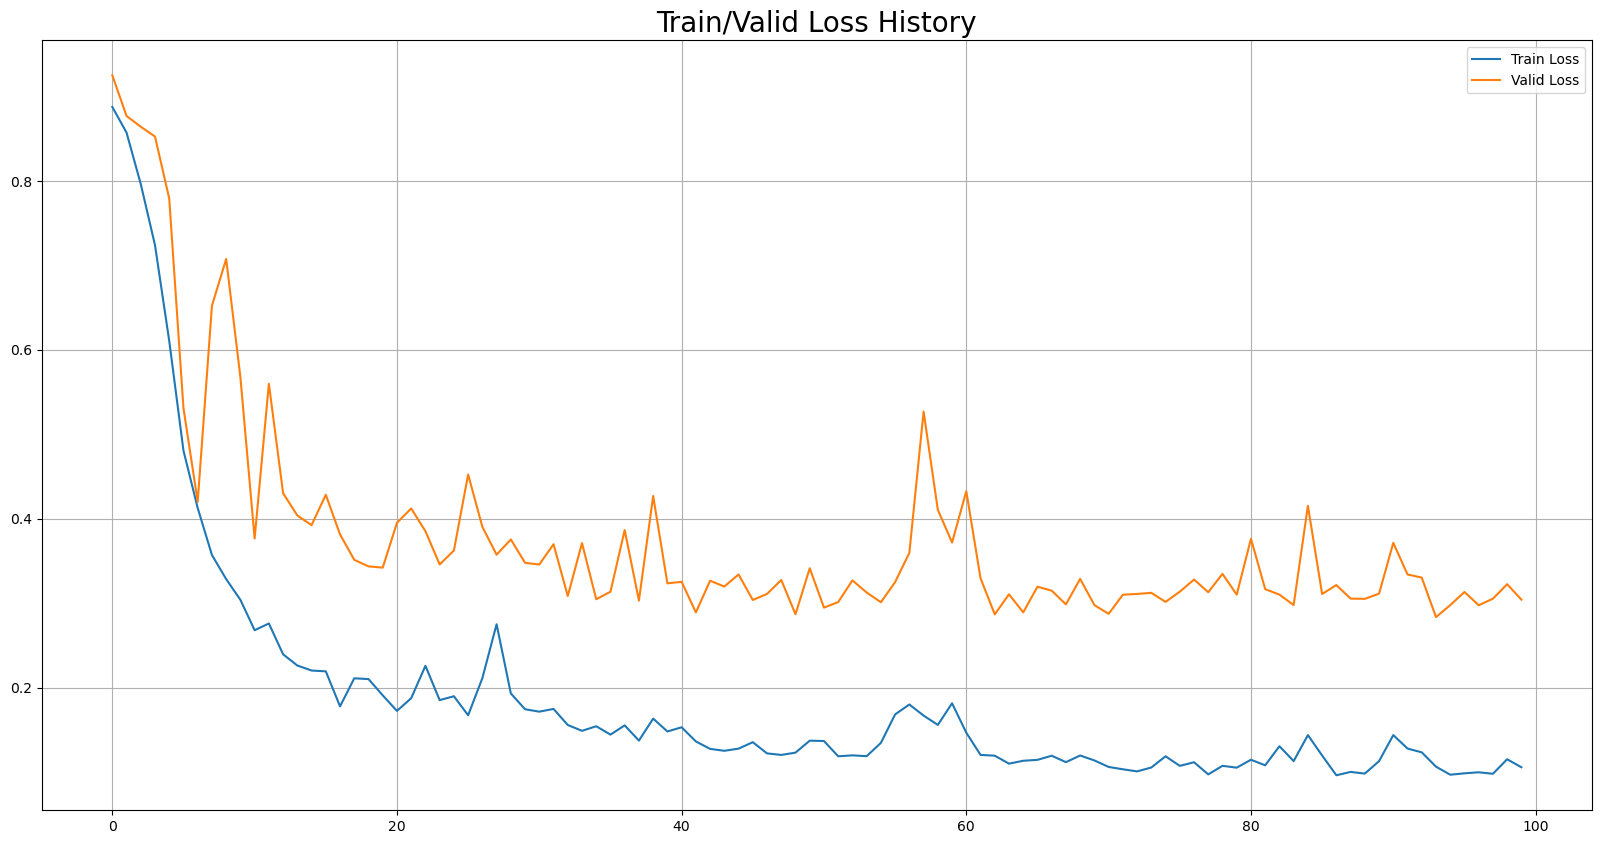

In [37]:
# Loss vs Epochs
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

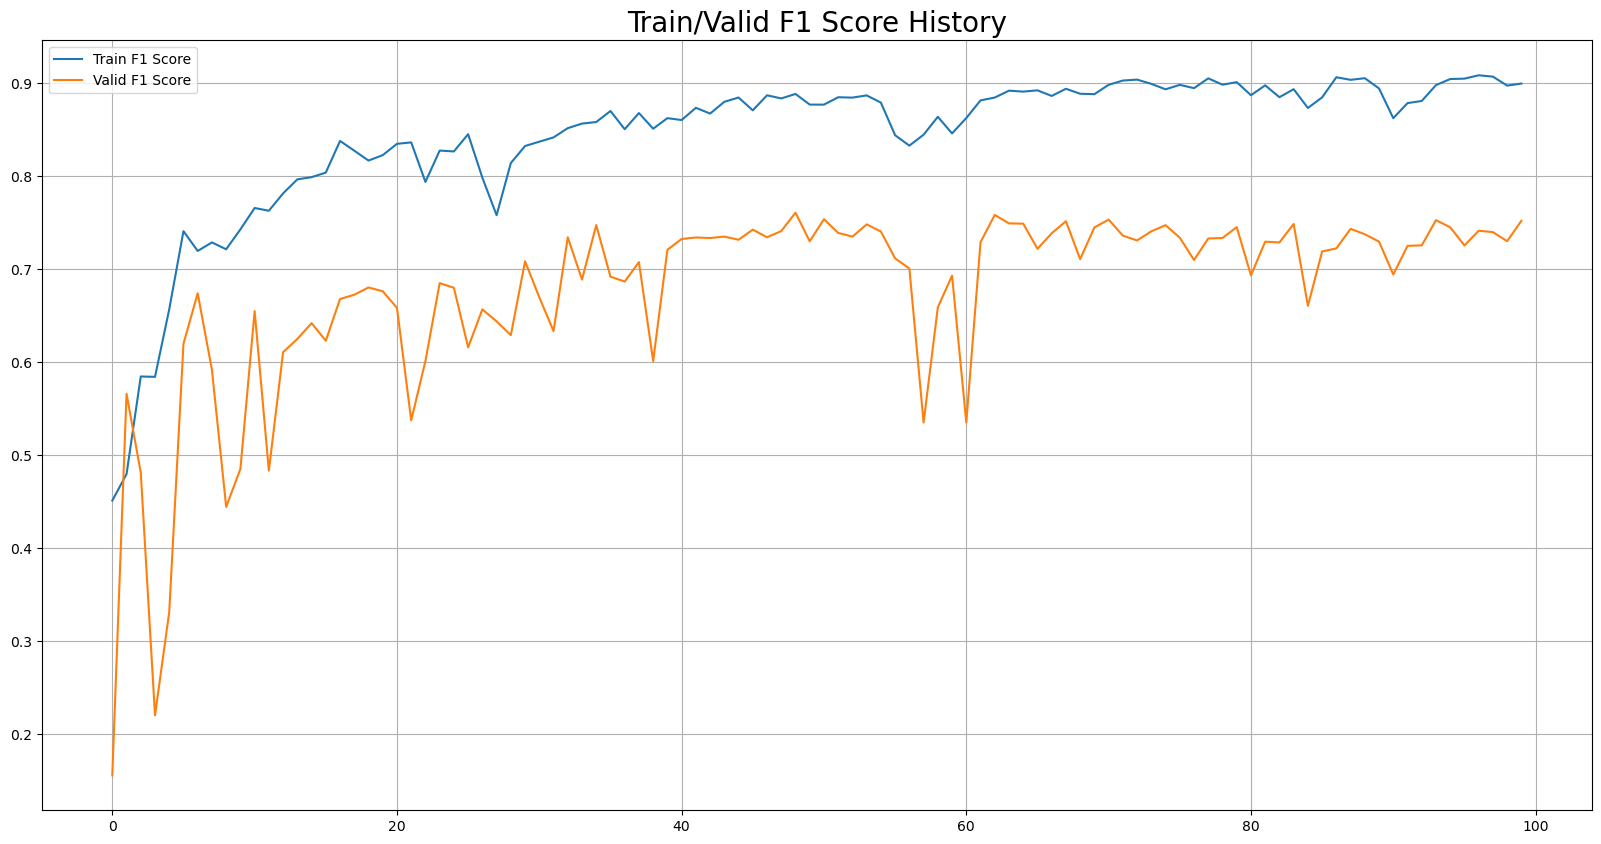

In [38]:
# F1 score vs epochs
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid F1 Score History", fontsize = 20)
plt.plot(
    range(0, len(result['Train F1 Score'][plot_from:])), 
    result['Train F1 Score'][plot_from:], 
    label = 'Train F1 Score'
    )

plt.plot(
    range(0, len(result['Valid F1 Score'][plot_from:])), 
    result['Valid F1 Score'][plot_from:], 
    label = 'Valid F1 Score'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

# F1Model

In [39]:
# loads a model that was trained with the F1 loss function
model.load_state_dict(torch.load('/kaggle/working/model_f1.bin'))

<All keys matched successfully>

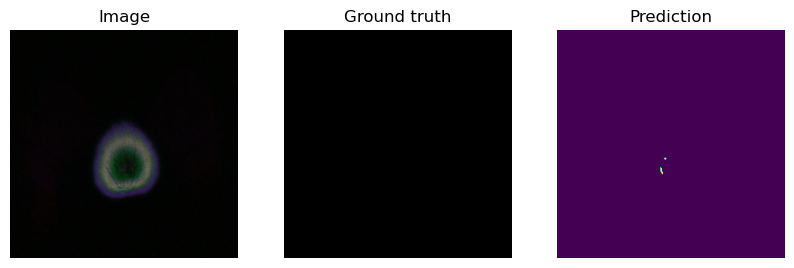

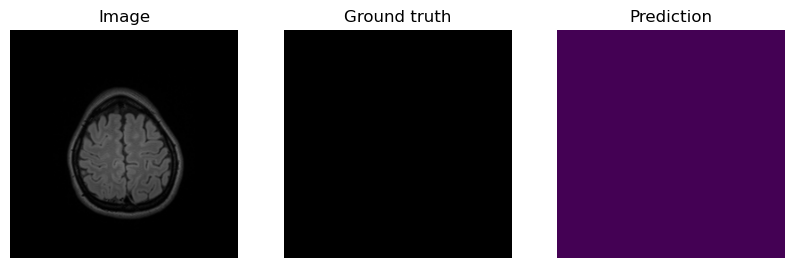

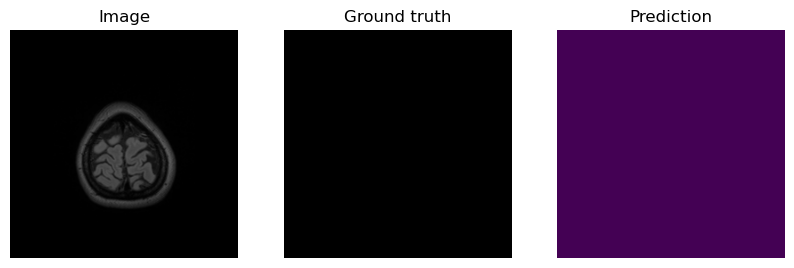

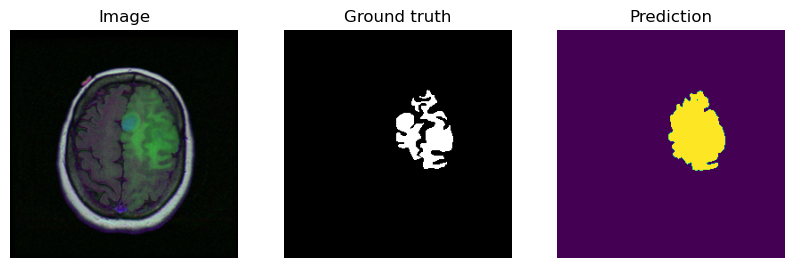

In [51]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].cuda())
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
#As imshow is used,we need to transpose the dimensions of 
#the tensor to match the expected input format
    plt.imshow(image.numpy().transpose(1, 2, 0))  # chw - hwc as per imshow's expectations
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
#Since there is only one class, the squeeze() method is used to remove the 
#channel dimension and obtain a 2D grayscale image where the pixel values 
#range from 0 (black) to 1 (white).
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

##  Loss Model

In [41]:
model.load_state_dict(torch.load('/kaggle/working/model.bin'))

<All keys matched successfully>

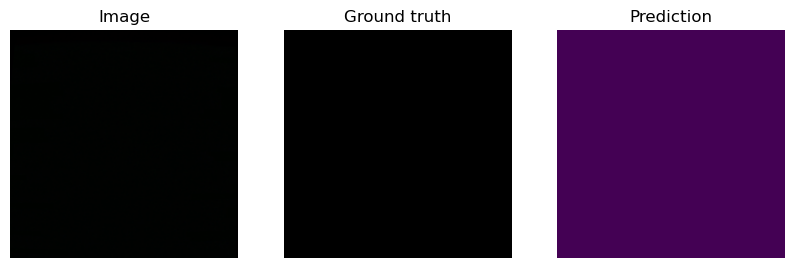

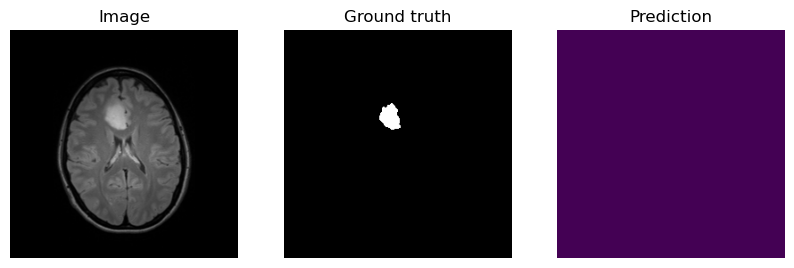

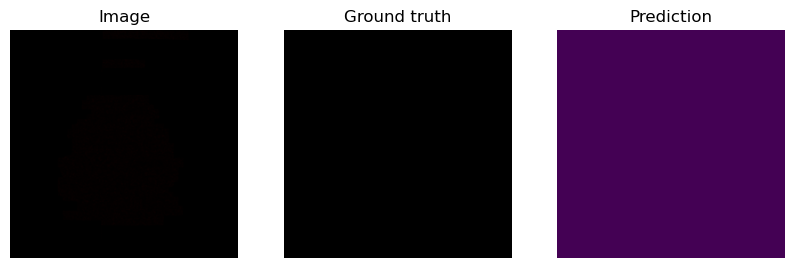

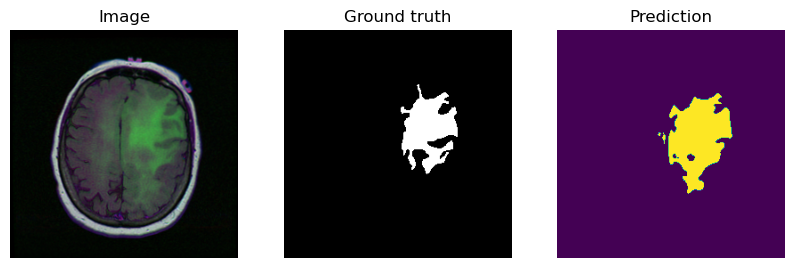

In [42]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# References:

https://github.com/zhixuhao/unet (U-net model original creator referenced)

https://www.kaggle.com/code/samuelcortinhas/case-study-u-net-from-scratch#Application:-Tumor-detection

https://www.kaggle.com/code/tejasurya/unet-from-scratch-segmentation-tumour/notebook

https://www.kaggle.com/code/heiswicked/pytorch-unet-segmentation-tumour

